# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* ロビンソン・クルーソー経済を解く
* 3期間モデルの拡張

In [1]:
using Dierckx
using Optim
using Plots
#pyplot() # これがないと日本語表示がおかしくなるかも

In [2]:
# グリッドを生成するためのモジュールを読み込む
include("GenerateGrid.jl")

Main.GenerateGrid

### カリブレーション
* パラメータをひとつの変数にまとめる：structを使う

In [3]:
struct Params
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    α::Float64 #資本分配率
    δ::Float64 #固定資本減耗

    T::Int64 #無人島に滞在する年数

    # グリッド
    nk::Int64 #資本グリッドの数
    kmax::Float64 #資本グリッドの最大値
    kmin::Float64 #資本グリッドの最小値
    kgrid::Vector{Float64} #資本グリッド
end

In [4]:
function calibration()
    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0
    T = 10

    nk = 11
    kmax = 1.0
    kmin = 0.05

    # 自作のコードで等分のグリッドを計算
    kgrid = GenerateGrid.grid_uni(kmin, kmax, nk)
    # これまで通り⬇でもOK
    #kgrid = collect(LinRange(kmin, kmax, nk))

    return Params(β, γ, α, δ, T, nk, kmax, kmin, kgrid)
end

calibration (generic function with 1 method)

In [5]:
params = calibration();

---

## 経済学でよく使う関数

In [6]:
include("MyEconFcn.jl")

Main.MyEconFcn

---

## 後ろ向きに解いていく
* **similar**は引数と同じサイズの変数を確保するための関数
* 変数の中身が初期化されていない(=どんな値が入っているか事前にはわからない)点に注意

In [7]:
# 変数を定義
pfcn = zeros(params.nk, params.T) # 政策関数
vfcn = similar(pfcn) # 価値関数
cfcn = similar(pfcn) # 消費関数
wealth = params.kgrid.^params.α; # 利用可能な資産

In [8]:
# 試しに中身を確認してみる
vfcn

11×10 Matrix{Float64}:
 1.0e-323      2.62682e-314  3.0e-323      …  5.0e-324      2.65002e-314
 5.0e-324      3.0e-323      2.64986e-314     2.65002e-314  5.0e-324
 2.35133e-314  4.4e-323      5.0e-324         5.0e-324      2.65002e-314
 1.5e-323      2.62682e-314  2.64986e-314     2.65002e-314  5.0e-324
 1.0e-323      4.0e-323      5.0e-324         5.0e-324      2.65002e-314
 2.63961e-314  2.5e-323      2.65002e-314  …  2.65002e-314  5.0e-324
 2.5e-323      2.62682e-314  5.0e-324         5.0e-324      2.65002e-314
 1.5e-323      4.4e-323      2.65002e-314     2.65002e-314  5.0e-324
 2.35133e-314  4.0e-323      5.0e-324         5.0e-324      2.65002e-314
 5.0e-323      0.0           2.65002e-314     2.65002e-314  2.19693e-314
 4.4e-323      4.4e-323      5.0e-324      …  5.0e-324      2.19704e-314

### 最終期の価値関数

In [9]:
# 最終期(全てを消費)
pfcn[:, end] .= 0.0 # 全て消費するので貯蓄はゼロ
cfcn[:, end] = wealth
vfcn[:, end] = MyEconFcn.crra.(cfcn[:, end], params.γ); # 消費から得られる効用

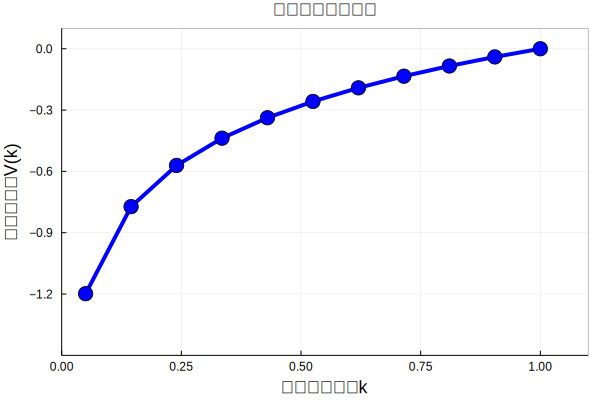

In [10]:
# 最終期の価値関数(=効用関数)を試しにプロットしてみる
plt = plot(params.kgrid, vfcn[:, end],
    color = :blue,
    marker = :circle,
    legend = :none,
    title = ("最終期の価値関数"),
    xlims = (0, 1.1),
    ylims = (-1.5, 0.1),
    xlabel = ("現在の資本：k"),
    ylabel = ("価値関数：V(k)"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)

### 後ろ向きに繰り返し計算
* 2.5節で学習した**最適化（optimization）**を使う

In [11]:
"""
k'を1つ与えた際にベルマン方程式を返す

### インプット
`params::Params`: パラメータなどをまとめた変数
`wealth::Float64`: 今期利用可能な資産
`kprime::Float64`: 次期の資本量
`vnext`: 補間した次期の価値関数

# アウトプット 
`value::Float64`: 負値にしたベルマン方程式
"""
function BellmanEq(params::Params, wealth::Float64, kprime::Float64, vnext::Spline1D)
    cons = wealth - kprime
    current_util = MyEconFcn.crra(cons, params.γ)
    value = current_util + params.β*vnext(kprime)
    value = -1*value
    return value
end

BellmanEq

In [12]:
for t = params.T-1:-1:1 # 滞在期間について後ろから解いていく

    #次期の価値関数を補間
    #vnext = Spline1D(m.kgrid, vfcn[:, t+1], k=1, bc="extrapolate") # 線形補間
    vnext = Spline1D(params.kgrid, vfcn[:, t+1], k=3, bc="extrapolate") # スプライン補間

    for i = 1:params.nk # 状態変数kについてループを行う

        BellmanEq!(kprime) = BellmanEq(params, wealth[i], kprime, vnext)
        res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) #最適化

        pfcn[i, t] = res.minimizer
        vfcn[i, t] = -res.minimum # 最小値を探していたので符号を反転させる
    end

    #消費関数を計算
    cfcn[:, t] = params.kgrid.^params.α - pfcn[:, t]
end

In [13]:
"""
最適化(optimization)と内挿法(interpolation)をつかってロビンソン・クルーソー経済を解く.

# インプット
-`params::Models`: パラメータを含む構造体

# アウトプット 
-`vfcn::Matrix{Float64,2}`: 価値関数
-`pfcn::Matrix{Float64,2}`: 政策関数
-`cfcn::Matrix{Float64,2}`: 消費関数
"""
function Robinson_crusoe(params)

    # 変数を定義
    pfcn = zeros(params.nk, params.T) # 政策関数
    vfcn = similar(pfcn) # 価値関数
    cfcn = similar(pfcn) # 消費関数
    wealth = params.kgrid.^params.α; # 利用可能な資産

    # 最終期(全てを消費)
    pfcn[:, end] .= 0.0 # 全て消費するので貯蓄はゼロ
    cfcn[:, end] = wealth
    vfcn[:, end] = MyEconFcn.crra.(cfcn[:, end], params.γ); # 消費から得られる効用
    
    # メインループ
    for t = params.T-1:-1:1 # 滞在期間について後ろから解いていく

        #次期の価値関数を補間
        #vnext = Spline1D(m.kgrid, vfcn[:, t+1], k=1, bc="extrapolate") # 線形補間
        vnext = Spline1D(params.kgrid, vfcn[:, t+1], k=3, bc="extrapolate") # スプライン補間

        for i = 1:params.nk # 状態変数kについてループを行う

            BellmanEq!(kprime) = BellmanEq(params, wealth[i], kprime, vnext)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) #最適化

            pfcn[i, t] = res.minimizer
            vfcn[i, t] = -res.minimum # 最小値を探していたので符号を反転させる
        end

        #消費関数を計算
        cfcn[:, t] = params.kgrid.^params.α - pfcn[:, t]
    end
    
    return vfcn, pfcn, cfcn
end

Robinson_crusoe

In [14]:
# 計算時間を計測
@time vfcn, pfcn, cfcn = Robinson_crusoe(params);

  0.129117 seconds (245.06 k allocations: 12.723 MiB, 99.74% compilation time)


---

## 計算誤差を確認するために解析的解を計算

In [15]:
# 解析的解
p_true = zeros(params.nk, params.T)

for t = 1:params.T, i = 1:params.nk
    p_true[i, t] = params.α * params.β * ((1.0-(params.α*params.β)^(params.T-t)) / (1.0-(params.α*params.β)^(params.T-t+1))) * (params.kgrid[i]^params.α)
end

---

# プロット

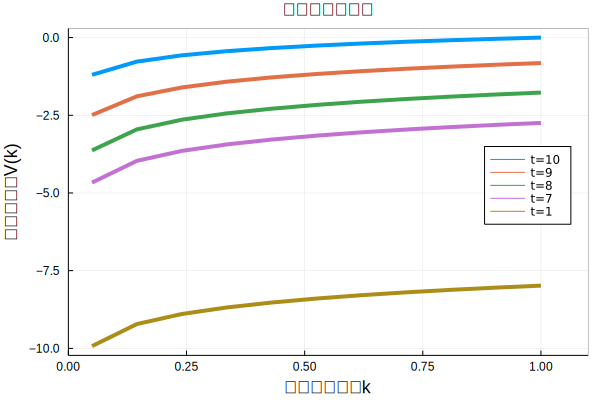

In [16]:
plt = plot(params.kgrid, vfcn[:, end],
    legend = :right,
    title = ("各期の価値関数"),
    xlims = (0, 1.1),
    label = ("t=10"),
    xlabel = ("現在の資本：k"),
    ylabel = ("価値関数：V(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.kgrid, vfcn[:, 9], linewidth =4, label="t=9")
plot!(params.kgrid, vfcn[:, 8], linewidth =4, label="t=8")
plot!(params.kgrid, vfcn[:, 7], linewidth =4, label="t=7")
plot!(params.kgrid, vfcn[:, 1], linewidth =4, label="t=1")

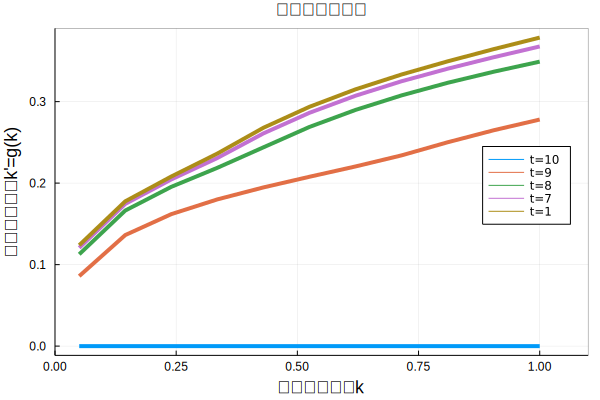

In [17]:
plt = plot(params.kgrid, pfcn[:, end],
    legend = :right,
    title = ("各期の政策関数"),
    xlims = (0, 1.1),
    label = ("t=10"),
    xlabel = ("現在の資本：k"),
    ylabel = ("次期の資本：k'=g(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.kgrid, pfcn[:, 9], linewidth =4, label="t=9")
plot!(params.kgrid, pfcn[:, 8], linewidth =4, label="t=8")
plot!(params.kgrid, pfcn[:, 7], linewidth =4, label="t=7")
plot!(params.kgrid, pfcn[:, 1], linewidth =4, label="t=1")

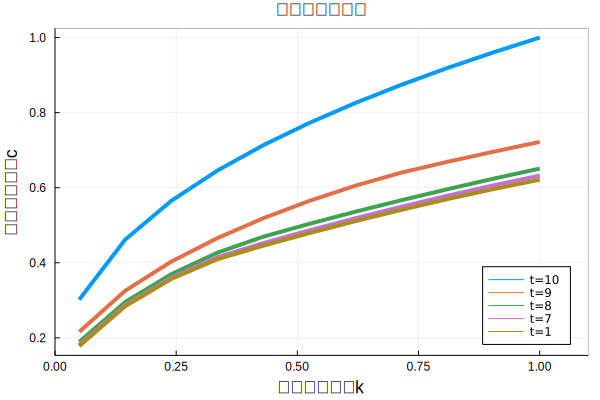

In [18]:
plt = plot(params.kgrid, cfcn[:, end],
    legend = :bottomright,
    title = ("各期の消費関数"),
    xlims = (0, 1.1),
    label = ("t=10"),
    xlabel = ("現在の資本：k"),
    ylabel = ("現在の消費：c"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.kgrid, cfcn[:, 9], linewidth =4, label="t=9")
plot!(params.kgrid, cfcn[:, 8], linewidth =4, label="t=8")
plot!(params.kgrid, cfcn[:, 7], linewidth =4, label="t=7")
plot!(params.kgrid, cfcn[:, 1], linewidth =4, label="t=1")

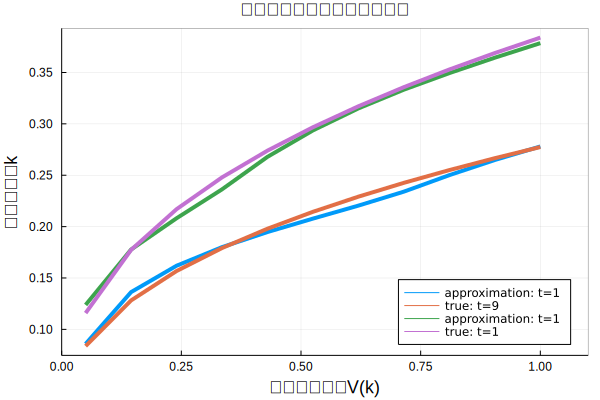

In [19]:
plt = plot(params.kgrid, pfcn[:, 9],
    legend = :bottomright,
    title = ("真の政策関数と近似した政策"),
    xlims = (0, 1.1),
    label = ("approximation: t=1"),
    xlabel = ("現在の資本：V(k)"),
    ylabel = ("価値関数：k"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.kgrid, p_true[:, 9], linewidth =4, label="true: t=9")
plot!(params.kgrid, pfcn[:, 1], linewidth =4, label="approximation: t=1")
plot!(params.kgrid, p_true[:, 1], linewidth =4, label="true: t=1")

---

## エクササイズ
* 真の政策関数と近似した政策関数の精度があまり良くないので、改善する方法を考えてみよう。